In [19]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from scipy.stats import hmean
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, average_precision_score
import re
import helper_functions
import seaborn as sns


In [2]:
# load data and filter simultaneously
DFVZ_PATH = '../DataFiles/experimental_data_set.csv'
DF20_PATH = '../DataFiles/df20.csv'

dfvz, df20 = helper_functions.load_and_filter_dataset(DFVZ_PATH, DF20_PATH, 'CPXXX')

/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)



    DF Contains: 
    Sequences Containing C: 2740
    Sequences Containing PXXX (Not PPXX): 4328
    Combine the two above filters with or: 6846 
    
Len Before Filtering for DFVZ and DF20: [67278 67278]
Len After Filter: [60432 60432]


In [3]:
# Scale and Pre-process data: This will store the various pre-processed forms of the data as dictionaries that can be
# use to easily access the data for different purposes.

X_dict, Xname_dict, y_dict = helper_functions.pre_process_data(dfvz=dfvz, df20=df20, threshold=.05)

(array([701.,   0.,   0., ...,   0.,   0.,   1.]),
 array([-4.439897  , -4.43985375, -4.4398105 , ..., -1.8262745 ,
        -1.82623125, -1.826188  ]),
 <BarContainer object of 60432 artists>)

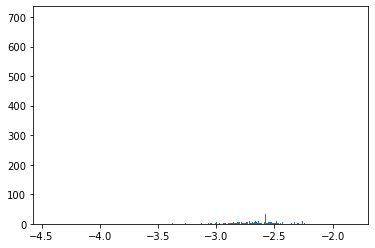

In [26]:
# Plot data distribution:
plt.hist(x=dfvz[['log.label']], bins=len(dfvz))

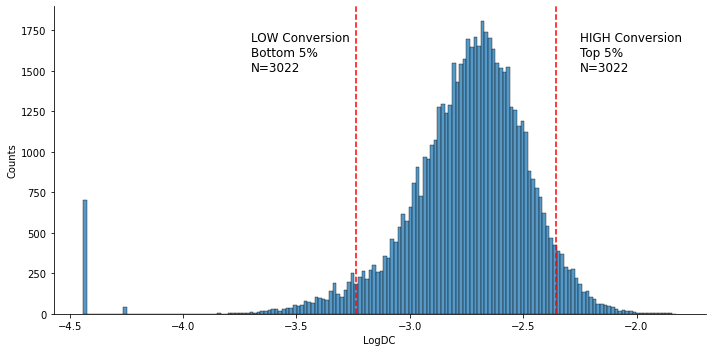

In [61]:
LOW_QUANTILE = dfvz['log.label'].quantile(0.05)
HIGH_QUANTILE = dfvz['log.label'].quantile(0.95)

g = sns.displot(dfvz['log.label'], kind='hist', height=5, aspect=2)

g.set_axis_labels("LogDC", "Counts")
g.set_titles("Distribution of LogDC Values with HIGH and LOW Class")
plt.axvline(LOW_QUANTILE, color='red', linestyle='--')
plt.axvline(HIGH_QUANTILE, color='red', linestyle='--')
plt.text(-3.7, 1500, 'LOW Conversion\nBottom 5%\nN=3022', fontsize='large', )
plt.text(-2.25, 1500, 'HIGH Conversion\nTop 5%\nN=3022', fontsize='large' )

plt.savefig(f'figures/Class_Distribution.svg')
plt.savefig(f'figures/Class_Distribution.png', dpi=300)


In [4]:
# Set optimized hyper params for the models:
model_params = {
    'gamma':0, #1 no effect
    'learning_rate':0.1,
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'n_estimators':200,
    'subsample':1,
    'colsample_bytree': 0.4,
    'colsample_bylevel':1,
    'random_state':42,
    'scale_pos_weight':6,
    'reg_alpha': 0 ,
    'reg_lambda':1,
    'base_score':0.5,
    'n_jobs':-1
}

# Set features for High Classifier - Will be used to evaluate and then save the final model:

X = X_dict['Xpvz_s'] # X now contains scaled features from both pattern and chemical feature datasets
y = y_dict['high'] # y now contains labels for the top 5 percentile vs the other 95%

skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mod_high = xgb.XGBClassifier(
   **model_params
)

Index(['..AA', '..AR', '..AN', '..AD', '..AC', '..AE', '..AQ', '..AG', '..AH',
       '..AI',
       ...
       'M...', 'F...', 'P...', 'S...', 'T...', 'W...', 'Y...', 'V...', 'seq',
       'label'],
      dtype='object', length=2398)
Index(['seq', 'label', 'log.label', 'z1.1', 'z1.2', 'z1.3', 'z2.1', 'z2.2',
       'z2.3', 'z3.1', 'z3.2', 'z3.3', 'z4.1', 'z4.2', 'z4.3', 'vhse1.1',
       'vhse1.2', 'vhse1.3', 'vhse1.4', 'vhse1.5', 'vhse1.6', 'vhse1.7',
       'vhse1.8', 'vhse2.1', 'vhse2.2', 'vhse2.3', 'vhse2.4', 'vhse2.5',
       'vhse2.6', 'vhse2.7', 'vhse2.8', 'vhse3.1', 'vhse3.2', 'vhse3.3',
       'vhse3.4', 'vhse3.5', 'vhse3.6', 'vhse3.7', 'vhse3.8', 'vhse4.1',
       'vhse4.2', 'vhse4.3', 'vhse4.4', 'vhse4.5', 'vhse4.6', 'vhse4.7',
       'vhse4.8'],
      dtype='object')


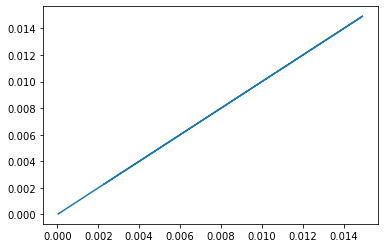

In [5]:
#sanity checks
print(df20.iloc[:,:].columns)
print(dfvz.iloc[:,:].columns)
print(plt.plot(dfvz['label'], df20['label']))

Fold #: 1
acc score: 0.92
roc score: 0.80
f1 score: 0.33
Precision score: 0.30
Recall score: 0.38
Average precision-recall score: 0.30


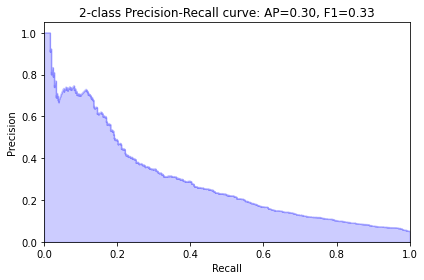

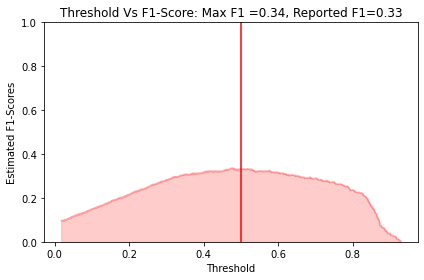

Recall: 0.38
Precision: 0.30


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10945,537
Positive,377,228


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


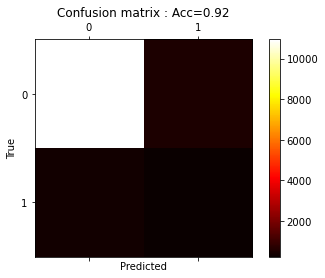

--------------------------------------------------------
Fold #: 2
acc score: 0.92
roc score: 0.80
f1 score: 0.33
Precision score: 0.29
Recall score: 0.38
Average precision-recall score: 0.27


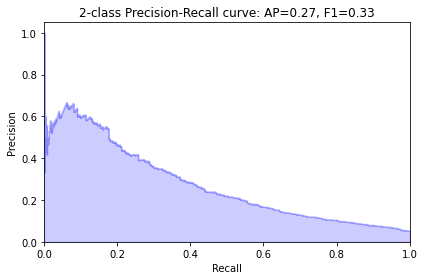

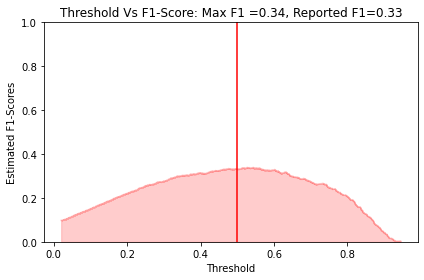

Recall: 0.38
Precision: 0.29


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10935,547
Positive,377,228


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


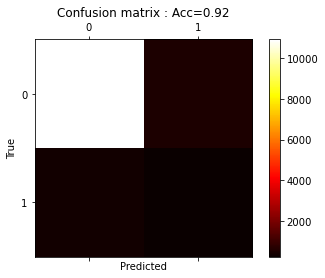

--------------------------------------------------------
Fold #: 3
acc score: 0.93
roc score: 0.81
f1 score: 0.35
Precision score: 0.31
Recall score: 0.41
Average precision-recall score: 0.27


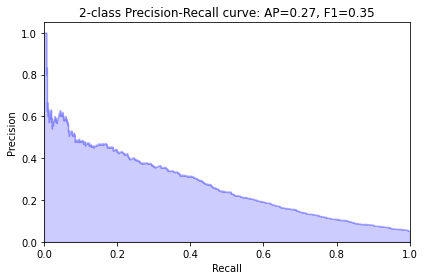

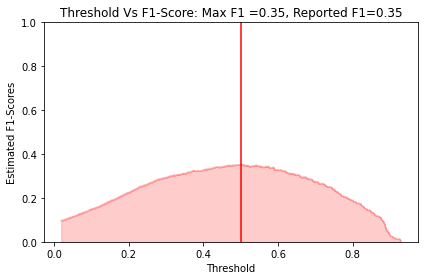

Recall: 0.41
Precision: 0.31


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10937,545
Positive,358,246


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


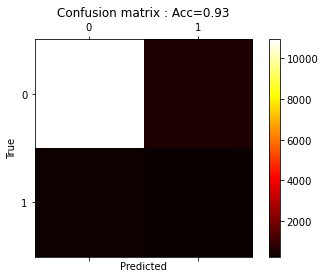

--------------------------------------------------------
Fold #: 4
acc score: 0.92
roc score: 0.81
f1 score: 0.31
Precision score: 0.29
Recall score: 0.34
Average precision-recall score: 0.26


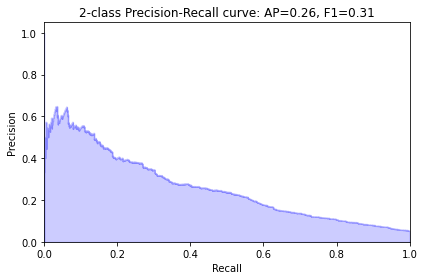

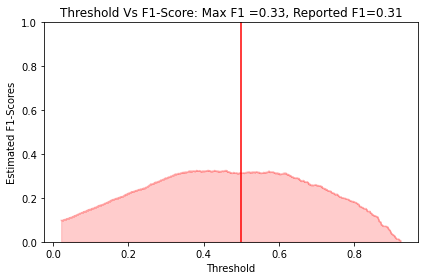

Recall: 0.34
Precision: 0.29


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10966,516
Positive,396,208


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


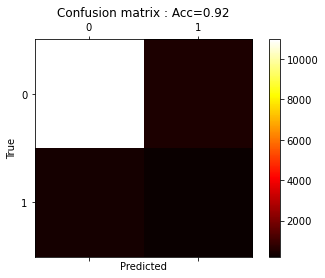

--------------------------------------------------------
Fold #: 5
acc score: 0.92
roc score: 0.81
f1 score: 0.32
Precision score: 0.29
Recall score: 0.37
Average precision-recall score: 0.29


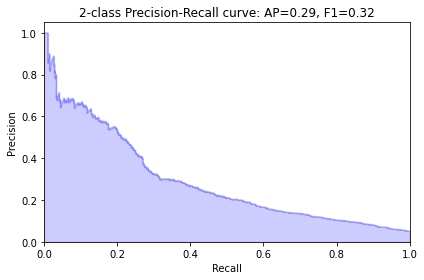

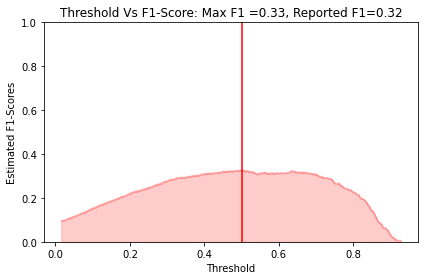

Recall: 0.37
Precision: 0.29


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,10921,561
Positive,378,226


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


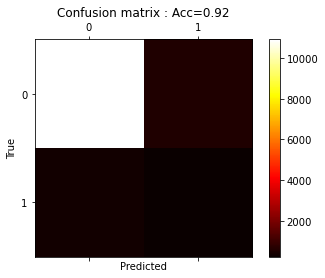

--------------------------------------------------------


In [6]:
# Evaluate HIGH Model
acc_dict = {}
roc_dict = {}
f1_dict = {}
prec_dict ={}
rec_dict ={}
aprec_dict = {}
i = 0

for train_index, test_index in skf5.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = i + 1

    print ('Fold #: ' + str(i))
    mod_high.fit(X_train, y_train)

    y_pred = mod_high.predict(X_test)
    y_score = mod_high.predict_proba(X_test)[:,1]

    acc_dict[i] = (y_pred == y_test).mean()
    roc_dict[i] = roc_auc_score(y_test, y_score)
    f1_dict[i] = f1_score(y_test, y_pred, average='binary')
    prec_dict[i] = precision_score(y_test, y_pred)
    rec_dict[i] = recall_score(y_test, y_pred)
    aprec_dict[i] = average_precision_score(y_test, y_score)

    print("acc score: {0:,.2f}".format(acc_dict[i]))
    print("roc score: {0:,.2f}".format(roc_dict[i]))
    print("f1 score: {0:,.2f}".format(f1_dict[i]))
    print("Precision score: {0:,.2f}".format(prec_dict[i]))
    print("Recall score: {0:,.2f}".format(rec_dict[i]))
    print('Average precision-recall score: {0:,.2f}'.format(aprec_dict[i]))

    #Plot the results
    helper_functions.evalplots(y_test,y_score,y_pred,[0, 1],f'HIGH_FOLD_{i}_CV')

In [7]:
for dt in [acc_dict,roc_dict,f1_dict,prec_dict,rec_dict,aprec_dict]:
    print(np.mean(list(dt.values())))
    print(np.std(list(dt.values())))
    print()


0.9240137690584348
0.0010153939324350821

0.8067942886067891
0.0032529407590227892

0.3308337527967588
0.012849699989961818

0.29553815448448423
0.008776830631881186

0.37590936456679985
0.019919420109338695

0.27963172559890836
0.013376269814568536



acc score: 0.94
roc score: 0.91
f1 score: 0.44
Precision score: 0.39
Recall score: 0.51
Average precision-recall score: 0.43


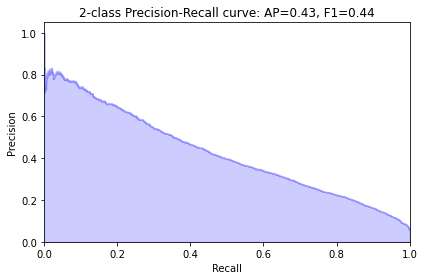

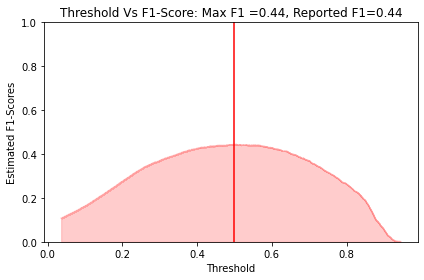

Recall: 0.51
Precision: 0.39


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,55013,2397
Positive,1478,1544


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


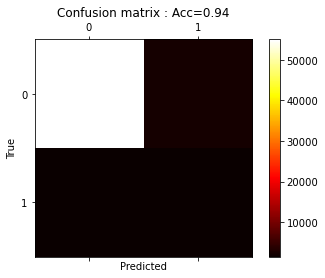

--------------------------------------------------------


In [8]:
#fit model to entire sample
mod_high = xgb.XGBClassifier(
    **model_params
)

mod_high.fit(X, y)

#training accuracy
y_pred = mod_high.predict(X)
y_score = mod_high.predict_proba(X)[:,1]

acc = (y_pred == y).mean()
roc = roc_auc_score(y, y_score)
f1 = f1_score(y, y_pred, average='binary')
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
aprec = average_precision_score(y, y_score)

print("acc score: {0:,.2f}".format(acc))
print("roc score: {0:,.2f}".format(roc))
print("f1 score: {0:,.2f}".format(f1))
print("Precision score: {0:,.2f}".format(prec))
print("Recall score: {0:,.2f}".format(rec))
print('Average precision-recall score: {0:,.2f}'.format(aprec))

#Plot the results
helper_functions.evalplots(y,y_score,y_pred,[0, 1], 'HIGH_FULL')

In [9]:
#save model to file
pickle.dump(mod_high, open("npx_mod_high_xgb_cor.pickle", "wb"))

## Low Model

In [10]:
mod_low = xgb.XGBClassifier(
    **model_params
)
X = X_dict['Xpvz_s'] # X now contains scaled features from both pattern and chemical feature datasets
y = y_dict['low'] # y now contains labels for the top 5 percentile vs the other 95%

Fold #: 1
acc score: 0.93
roc score: 0.71
f1 score: 0.13
Precision score: 0.16
Recall score: 0.11
Average precision-recall score: 0.12


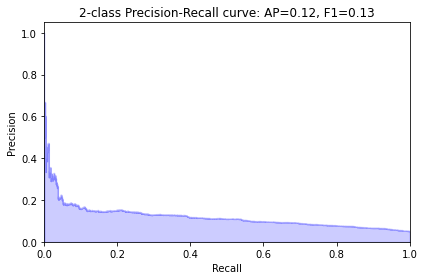

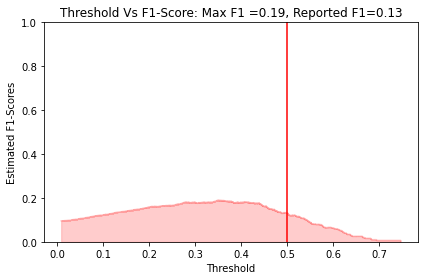

Recall: 0.11
Precision: 0.16


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11146,336
Positive,539,66


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


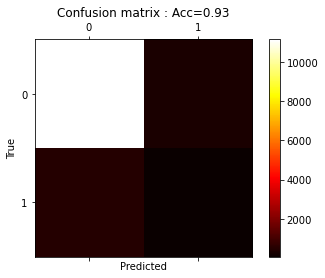

--------------------------------------------------------
Fold #: 2
acc score: 0.93
roc score: 0.74
f1 score: 0.14
Precision score: 0.17
Recall score: 0.11
Average precision-recall score: 0.13


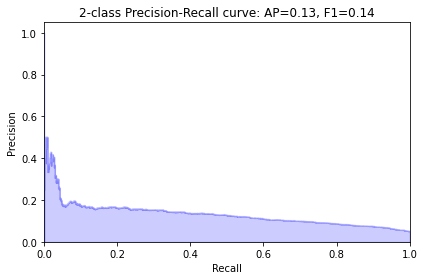

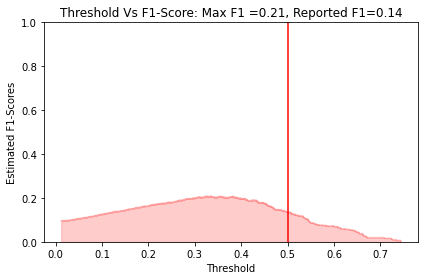

Recall: 0.11
Precision: 0.17


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11138,344
Positive,536,69


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


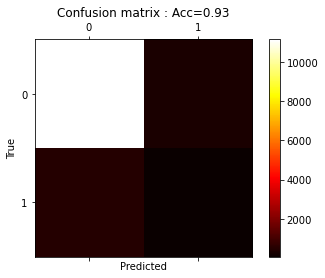

--------------------------------------------------------
Fold #: 3
acc score: 0.93
roc score: 0.73
f1 score: 0.11
Precision score: 0.15
Recall score: 0.09
Average precision-recall score: 0.12


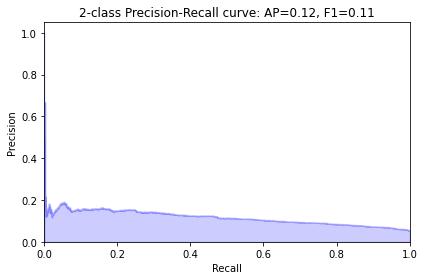

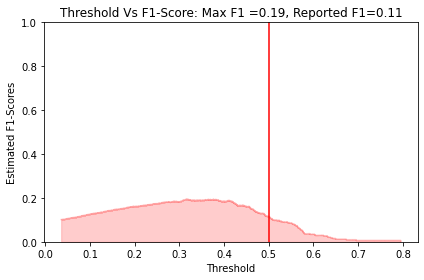

Recall: 0.09
Precision: 0.15


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11176,306
Positive,549,55


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


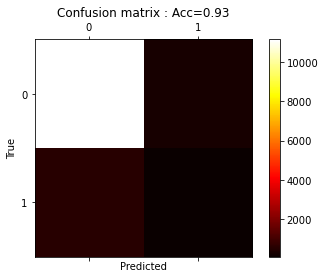

--------------------------------------------------------
Fold #: 4
acc score: 0.93
roc score: 0.73
f1 score: 0.13
Precision score: 0.18
Recall score: 0.11
Average precision-recall score: 0.13


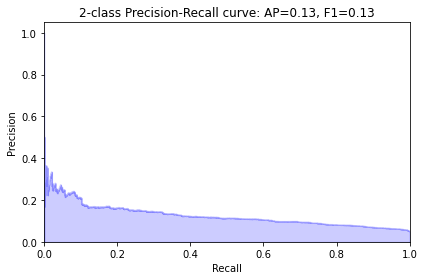

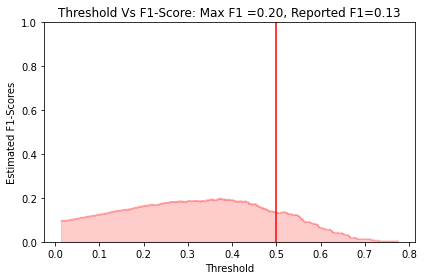

Recall: 0.11
Precision: 0.18


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11186,296
Positive,539,65


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


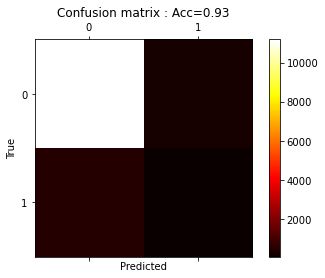

--------------------------------------------------------
Fold #: 5
acc score: 0.93
roc score: 0.73
f1 score: 0.13
Precision score: 0.17
Recall score: 0.11
Average precision-recall score: 0.12


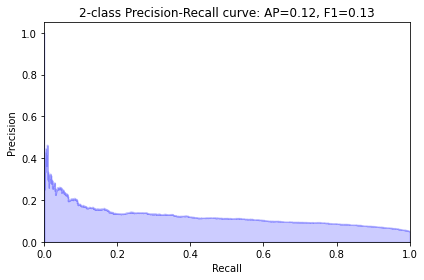

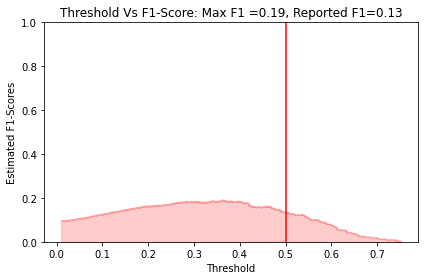

Recall: 0.11
Precision: 0.17


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,11145,337
Positive,536,68


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


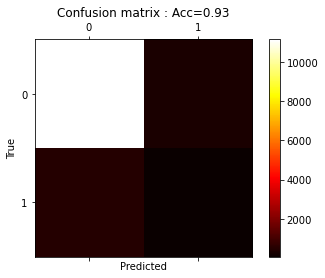

--------------------------------------------------------


In [12]:
# Evaluate LOW Model
acc_dict = {}
roc_dict = {}
f1_dict = {}
prec_dict ={}
rec_dict ={}
aprec_dict = {}
i = 0

for train_index, test_index in skf5.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = i + 1

    print ('Fold #: ' + str(i))
    mod_low.fit(X_train, y_train)

    y_pred = mod_low.predict(X_test)
    y_score = mod_low.predict_proba(X_test)[:,1]

    acc_dict[i] = (y_pred == y_test).mean()
    roc_dict[i] = roc_auc_score(y_test, y_score)
    f1_dict[i] = f1_score(y_test, y_pred, average='binary')
    prec_dict[i] = precision_score(y_test, y_pred)
    rec_dict[i] = recall_score(y_test, y_pred)
    aprec_dict[i] = average_precision_score(y_test, y_score)

    print("acc score: {0:,.2f}".format(acc_dict[i]))
    print("roc score: {0:,.2f}".format(roc_dict[i]))
    print("f1 score: {0:,.2f}".format(f1_dict[i]))
    print("Precision score: {0:,.2f}".format(prec_dict[i]))
    print("Recall score: {0:,.2f}".format(rec_dict[i]))
    print('Average precision-recall score: {0:,.2f}'.format(aprec_dict[i]))

    #Plot the results
    helper_functions.evalplots(y_test,y_score,y_pred,[0, 1], f'LOW_FOLD_{i}_CV')

In [13]:
for dt in [acc_dict,roc_dict,f1_dict,prec_dict,rec_dict,aprec_dict]:
    print(np.mean(list(dt.values())))
    print(np.std(list(dt.values())))
    print()

0.9285478271937686
0.0013721773637090685

0.7303060961575703
0.010627974425848051

0.13002678508120788
0.008167723586468001

0.16631210585247153
0.008846928595169518

0.10687975480269278
0.008241836227266167

0.12333849939702546
0.005457659697390101



acc score: 0.94
roc score: 0.88
f1 score: 0.33
Precision score: 0.39
Recall score: 0.29
Average precision-recall score: 0.32


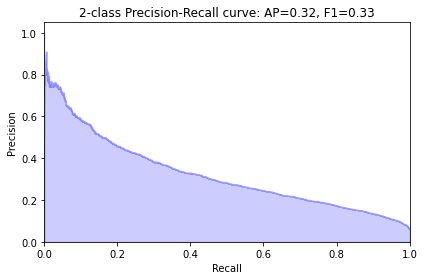

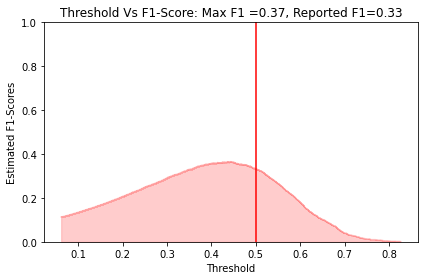

Recall: 0.29
Precision: 0.39


/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,Negative,Positive
Negative,56080,1330
Positive,2157,865


/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/mnt/WORKDRIVE/GitHub/GESAR-V2/MLNotebooks/helper_functions.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


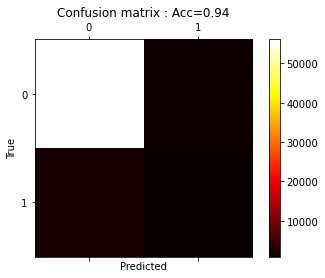

--------------------------------------------------------


In [14]:
#fit model to entire sample (low model)
mod_low = xgb.XGBClassifier(
    **model_params
)

mod_low.fit(X, y)

#training accuracy
y_pred = mod_low.predict(X)
y_score = mod_low.predict_proba(X)[:,1]

acc = (y_pred == y).mean()
roc = roc_auc_score(y, y_score)
f1 = f1_score(y, y_pred, average='binary')
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
aprec = average_precision_score(y, y_score)

print("acc score: {0:,.2f}".format(acc))
print("roc score: {0:,.2f}".format(roc))
print("f1 score: {0:,.2f}".format(f1))
print("Precision score: {0:,.2f}".format(prec))
print("Recall score: {0:,.2f}".format(rec))
print('Average precision-recall score: {0:,.2f}'.format(aprec))

#Plot the results
helper_functions.evalplots(y,y_score,y_pred,[0, 1], 'LOW_FULL')

In [15]:
#save model to file
pickle.dump(mod_low, open("npx_mod_low_xgb_cor.pickle", "wb"))

In [62]:
# This mode allows for backwards and forwards compatibility
mod_low.save_model('xgb_low_model.json')
mod_high.save_model('xgb_high_model.json')

## Use Final Models to Make Predictions:

1. Load 160k data set with features (feats)
2. Run both HIGH and LOW models on data to create probability and predictions
3. Label sequences that we already know log dc values for add them.
4. Label all sequences that contain PXXX and C. Not PPXX

In [63]:
# Load 160k observations to be classified (these were constructed via a function, please see
# TODO helper_functions -> loadextdict
feats = pickle.load(open("feature_160k.pickle", "rb"))

# Generate predictions (probabilities)
low_probs = mod_low.predict_proba(feats.values)[:,1]
high_probs = mod_high.predict_proba(feats.values)[:,1]

In [67]:
pred_df = pd.DataFrame(index=feats.index)
pred_df['low_probs']=low_probs
pred_df['high_probs'] = high_probs


In [69]:
# Label sequences containing PXXX and C (Not PPXX)
pred_df['Filter(C)and(PXXX)'] = False
filter_c_pxxx = pred_df.index.str.contains('(^P[^P])|([C])')
pred_df.loc[filter_c_pxxx, 'Filter(C)and(PXXX)'] = True

/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [81]:
# Add a new column with known logDC values
dfvz.set_index('seq', inplace=True)
combined = pd.concat([pred_df, dfvz['log.label']], axis=1, join='outer')

# Save df:
combined.to_csv('Predictions-160-Probabilities.csv')